## RESUME CLASSIFICATION WITH BERT | HUGGING FACE

### What is BERT
* Bidirectional encoders representations from Transformers
* In order to understand the text you are looking for you have to look for the words that come before and after (non directional) 
* LSTMS read sequentially  (right to left or left to right)
* BERT offers contexualized word embeddings

#### How was it trained
* Masked Language Modelling - hiding/masking 15% of the tokens and the goal is to guess them
* Next sentence modelling - Given a pair of two sentences , the task is to say whether or not the second follows the first

#### Why BERTS
* You can do transfer learning for many NLP Tasks namely

  ** Classification

  ** Question Answering

  ** Entity recognition e.t.c




### SETUP

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
# !pip install transformers

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")


In [4]:
device

device(type='cpu')

### Data Exploration

In [5]:
# path = '/content/drive/MyDrive/RESUME_YG/'
df = pd.read_csv('/kaggle/input/resume/UpdatedResumeDataSet1.csv')

In [6]:
display(df.head(), df.shape, df.isnull().sum())

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


(962, 2)

Category    0
Resume      0
dtype: int64

Text(0.5, 0, 'Category Distributions')

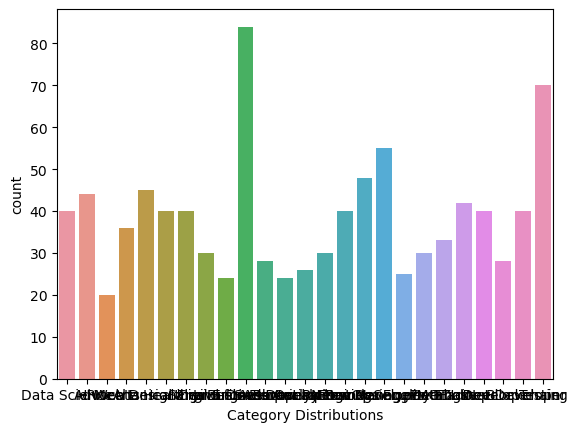

In [7]:
sns.countplot(x='Category', data=df)
plt.xlabel('Category Distributions')

In [8]:
df['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

The categories are almost equally balanced 

### Data Preprocessing
* Machine Learning models don't work with text, You have to convert the text into numbers

#### What does BERT require in preprocessing?
* Add special tokens to separate sentences and do classification
*Pass sequences of constant length (introduce padding)
* Create array of Os (pad token) and 1s (real token)
* Bert handles all the above through a tokenizer that is specific to the pretrained model you are using



#### Pretrained Models in BERT
* We have cased version and uncased version- this deals with capitalization 

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

### Bert Tokenizer 

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### Let us Understand the tokenization process
* Tokenization is the process of breaking down a text into small chunks called tokens. It is used in natural language processing (NLP) to identify individual words, phrases, or other meaningful units of text. By breaking an input text into tokens, an NLP system can more easily identify patterns, identify meaning, and draw insights from the text. Tokenization helps to make NLP tasks such as part-of-speech tagging, lemmatization, and named entity recognition more accurate.

In [11]:
sample_text = 'I started learning Machine Learning this year because I wanted to excel in my End of Year Project'

In [12]:
tokens = tokenizer.tokenize(sample_text) # converts the raw text to tokens 
token_ids = tokenizer.convert_tokens_to_ids(tokens) # converts the tokens to unique integers 

print(f'sentence: {sample_text}')
print(f' Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

sentence: I started learning Machine Learning this year because I wanted to excel in my End of Year Project
 Tokens: ['I', 'started', 'learning', 'Machine', 'Learning', 'this', 'year', 'because', 'I', 'wanted', 'to', 'ex', '##cel', 'in', 'my', 'End', 'of', 'Year', 'Project']
Token IDs: [146, 1408, 3776, 7792, 9681, 1142, 1214, 1272, 146, 1458, 1106, 4252, 18389, 1107, 1139, 5135, 1104, 2381, 4042]


##### Special Tokens
* [SEP] marker for ending of a sentence
* [CLS] marker for start of a sentence
* [PAD] Adding zeros to match the max_length of tokens

In [13]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [14]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

### Encode Plus Method
* Does all the above

In [15]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = 32,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors='pt',  
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored into a tensor and padded to length of 32


In [16]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146,  1408,  3776,  7792,  9681,  1142,  1214,  1272,   146,
         1458,  1106,  4252, 18389,  1107,  1139,  5135,  1104,  2381,  4042,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

The attention mask has the same length

In [17]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]

32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Reverse the tokenization process(from tokens to unique ids) and view the raw tokens

In [18]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'started',
 'learning',
 'Machine',
 'Learning',
 'this',
 'year',
 'because',
 'I',
 'wanted',
 'to',
 'ex',
 '##cel',
 'in',
 'my',
 'End',
 'of',
 'Year',
 'Project',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

#### Choosing Sequence length
* Bert works with fixed length sequences
* The max_length depends on what length is most of your inputs

In [19]:
token_lengths = []
for txt in df.Resume:
  tokens = tokenizer.encode(txt, truncation = True, max_length = 5000)
  token_lengths.append(len(tokens))


Text(0.5, 0, 'Token count')

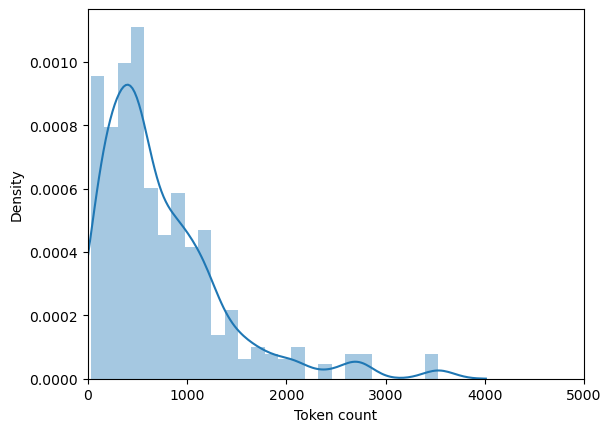

In [20]:
sns.distplot(token_lengths)
plt.xlim([0,5000])
plt.xlabel('Token count')

Most of them as below 3000 but bert is only restricted to 512 max_length 
* why?? Yes, BERT is often limited to a maximum length of 512 tokens. This is due to the size of the pre-trained models, which use up a lot of memory. As a result, longer sequences need to be truncated in order to fit into the memory.

In [21]:
MAX_LEN = 512

### Create a Pytorch Dataset

In [22]:
class ResumeDataset(Dataset):
  def __init__(self, resumes, targets, tokenizer, max_len):
    self.resumes = resumes
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.resumes)

  def __getitem__(self, item):
    resume = str(self.resumes[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
        resume,
        add_special_tokens = True,
        max_length = self.max_len,
        truncation = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    return {
        'resume_text': resume,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype = torch.long)        
    }


### Label encode the targets and get their mapping

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])
category_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
category_mapping

{'Advocate': 0,
 'Arts': 1,
 'Automation Testing': 2,
 'Blockchain': 3,
 'Business Analyst': 4,
 'Civil Engineer': 5,
 'Data Science': 6,
 'Database': 7,
 'DevOps Engineer': 8,
 'DotNet Developer': 9,
 'ETL Developer': 10,
 'Electrical Engineering': 11,
 'HR': 12,
 'Hadoop': 13,
 'Health and fitness': 14,
 'Java Developer': 15,
 'Mechanical Engineer': 16,
 'Network Security Engineer': 17,
 'Operations Manager': 18,
 'PMO': 19,
 'Python Developer': 20,
 'SAP Developer': 21,
 'Sales': 22,
 'Testing': 23,
 'Web Designing': 24}

In [24]:
df.head()

,Category,Resume
0,6,Skills * Programming Languages: Python (pandas...
1,6,Education Details \r\nMay 2013 to May 2017 B.E...
2,6,"Areas of Interest Deep Learning, Control Syste..."
3,6,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,6,"Education Details \r\n MCA YMCAUST, Faridab..."


The tokenizer will do most of the work for us

### Splitting DF into train and validation sets
* Best way Stratified KFold but since our data is less and is not imbalanced we will use a simple train_test_split and make sure the means of the targets are almost identical through stratifying

In [25]:
df_train, df_test = train_test_split(df, test_size = 0.15, random_state = RANDOM_SEED, stratify = df['Category'])
df_train.shape,  df_test.shape

((817, 2), (145, 2))

In [26]:
df_train['Category'].mean(), df_test['Category'].mean()

(12.95593635250918, 13.041379310344828)

### Creating DataLoaders

In [27]:
def create_data_loader(df, tokenizer,max_len, batch_size):
  ds = ResumeDataset(
  resumes = df.Resume.to_numpy(),
  targets = df.Category.to_numpy(),
  tokenizer = tokenizer,
  max_len = max_len


  )

  return DataLoader(
    ds,
    batch_size = batch_size,
    num_workers = 4    
  )
  

In [28]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

An example from our training data loader

In [29]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['resume_text', 'input_ids', 'attention_mask', 'targets'])

In [30]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([4, 512])
torch.Size([4, 512])
torch.Size([4])


### RESUME CLASSIFICATION WITH BERT AND HUGGING FACE

In [31]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)
bert_model.config.hidden_size

768

In [33]:
class ResumeClassifier(nn.Module):
  def __init__(self, n_classes):
    super(ResumeClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward (self,input_ids, attention_mask):
    _, pooled_output= self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)



* Dropout is used for regularization
* Fully connected layer for our output
* Raw output is returned in the last layer since its required for the cross_entropy loss function

In [34]:
model = ResumeClassifier(df['Category'].nunique())
model = model.to(device)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape, attention_mask.shape)


torch.Size([4, 512]) torch.Size([4, 512])


Apply softmax to get the predicted probabilities

In [36]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0218, 0.0159, 0.0280, 0.0856, 0.0281, 0.0304, 0.0372, 0.0390, 0.0512,
         0.0568, 0.0320, 0.0623, 0.0244, 0.0411, 0.0457, 0.0539, 0.0269, 0.0402,
         0.0245, 0.0423, 0.0524, 0.0340, 0.0530, 0.0419, 0.0313],
        [0.0170, 0.0181, 0.0264, 0.0678, 0.0333, 0.0246, 0.0451, 0.0398, 0.0457,
         0.0503, 0.0271, 0.0873, 0.0310, 0.0331, 0.0449, 0.0650, 0.0351, 0.0318,
         0.0250, 0.0398, 0.0448, 0.0314, 0.0576, 0.0451, 0.0327],
        [0.0169, 0.0201, 0.0273, 0.1124, 0.0338, 0.0338, 0.0309, 0.0427, 0.0498,
         0.0509, 0.0232, 0.0675, 0.0279, 0.0486, 0.0419, 0.0526, 0.0320, 0.0280,
         0.0233, 0.0395, 0.0406, 0.0328, 0.0493, 0.0465, 0.0277],
        [0.0228, 0.0190, 0.0260, 0.0729, 0.0389, 0.0274, 0.0418, 0.0424, 0.0378,
         0.0549, 0.0274, 0.0751, 0.0211, 0.0436, 0.0441, 0.0784, 0.0307, 0.0303,
         0.0221, 0.0378, 0.0474, 0.0349, 0.0518, 0.0458, 0.0255]],
       grad_fn=<SoftmaxBackward0>)

### Training

In [37]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr = 5e-5, correct_bias = False)
total_steps = len(train_data_loader)* EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = total_steps
)
loss_fn = nn.NLLLoss().to(device)

#### Parameter Recommendations for fine tuning?
* Batch size: 16, 32 an increase leads to faster execution but may interfere with accuracy
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs : 2,3, 4

In [38]:
from sklearn.metrics import accuracy_score, f1_score
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,  n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  y_true, y_pred = [], []
  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)
    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    y_true.extend(targets.cpu().tolist())
    y_pred.extend(preds.cpu().tolist())
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    accuracy = accuracy_score(y_true, y_pred)
    # f1 = f1_score(y_true, y_pred, average="macro")
    return np.mean(losses), accuracy

In [39]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)
      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim=1)      
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch: {epoch+1}/{EPOCHS}')
  print('-'* 10)

  train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,test_data_loader,loss_fn, device, len(df_test))
  print(f' Val loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    # torch.save(model.state_dict(),path + 'best_model_state.bin')
#     torch.save(model, path + 'best_model.pt')
    torch.save(model, '/kaggle/working/best_model.pt')
    best_accuracy = val_acc


Epoch: 1/5
----------
Train loss 0.0 accuracy 0.2515910267829895
 Val loss 0.03317991178482771 accuracy 0.013793103448275862
Epoch: 2/5
----------
Train loss 0.25 accuracy -0.26611050963401794
